# **Deep Generative Models: Variational Autoencoders and Generative Adversarial Networks**

# **CK Dataset**
In the following exercices, you will work with images extracted from the CK dataset: http://www.jeffcohn.net/wp-content/uploads/2020/02/Cohn-Kanade_Database.pdf.pdf

It contains gray-scale images of human faces.

The dataset is provided in the folder Data/faces/ in .mat format.
In the following we provide a Dataset class in pytorch to load images from this database.

Path is not defined, initialized to c:/Users/santo/Documents/GitHub/DeepLearning/P4
torch.Size([256, 1, 64, 64])


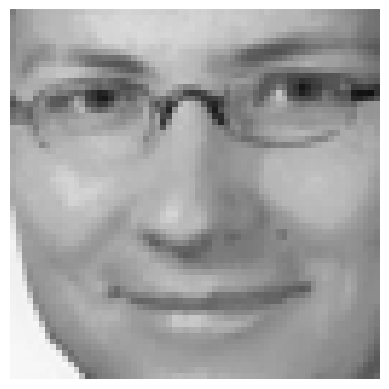

In [1]:
## Create a Custom Dataset for CK database
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Mount Google Drive

try:
    print("Currently on path", base_path)
except NameError:
    base_path = os.getcwd().replace('\\', '/')
    print("Path is not defined, initialized to", base_path)

data_path = base_path+'/Data/'
results_path = base_path+'/Results/'

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from torchvision.utils import make_grid



#Making native class loader
class FacesDB(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/faces/face_ims_64x64.mat', transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,0,index]   
        data = Image.fromarray(data,mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data

    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

import torchvision.transforms as transforms

tr = transforms.Compose([
        transforms.ToTensor(), 
        ])
faces_db = FacesDB(data_path+'/faces/face_ims_64x64.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=faces_db,
                                           batch_size=256, 
                                           shuffle=True)

# Mini-batch images
images = next(iter(train_loader))
print(images.shape)
image = images[0,:,:,:].repeat(3,1,1)
plt.imshow(image.permute(1,2,0).squeeze().numpy())
plt.axis('off')
plt.show()

# Ex. 1

In [2]:
'''
1. Following the example of the MNIST , train a VAE with the images we have provided for the CK dataset.
2. For every two epochs during training:
  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset
  2.2. Generate and show a set of images from random noise z. 
  2.3. Visualize a set of generated images by interpolating over the latent space z.
  2.4. Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.
'''

'\n1. Following the example of the MNIST , train a VAE with the images we have provided for the CK dataset.\n2. For every two epochs during training:\n  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset\n  2.2. Generate and show a set of images from random noise z. \n  2.3. Visualize a set of generated images by interpolating over the latent space z.\n  2.4. Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.\n'

In [3]:
import torch
import torch.nn as nn

# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))   
    return out

#  BatchNormnalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()
    self.layer1 = ConvBNReLU(1,base_channels,pooling=False)
    self.layer2 = ConvBNReLU(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU(base_channels*2,base_channels*4,pooling=True)
    self.fc = nn.Linear(16*16*base_channels*4,out_features)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    return self.fc(out.view(x.shape[0],-1))
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels
    self.fc = nn.Linear(out_features,16*16*base_channels*4)
    self.layer3 = BNReLUConv(base_channels*4,base_channels*2,pooling=True)
    self.layer2 = BNReLUConv(base_channels*2,base_channels,pooling=True)
    self.layer1 = BNReLUConv(base_channels,1,pooling=False)
  
  def forward(self,x):
    out = self.fc(x)
    out = out.view(x.shape[0],self.base_channels*4,16,16)
    out = self.layer3(out)
    out = self.layer2(out)
    out = self.layer1(out)
    return torch.sigmoid(out)

In [4]:
class VAE(nn.Module):
  def __init__(self, out_features=64,base_channels=16):
    super(VAE, self).__init__()
    # Initialize the encoder and decoder using a dimensionality out_features for the vector z
    self.out_features = out_features
    self.encoder = Encoder(out_features*2,base_channels)
    self.decoder = Decoder(out_features,base_channels)

  # function to obtain the mu and sigma of z for a samples x
  def encode(self,x):
    aux = self.encoder(x)
    # get z mean
    z_mean = aux[:,0:self.out_features]
    # get z variance
    z_log_var = aux[:,self.out_features::]
    return z_mean, z_log_var

  # function to generate a random sample z given mu and sigma
  def sample_z(self,z_mean,z_log_var):
    z_std = z_log_var.mul(0.5).exp() 
    samples_unit_normal = torch.randn_like(z_mean)
    samples_z = samples_unit_normal*z_std + z_mean
    return samples_z
  
  def forward(self,x):
    z_mean, z_log_var = self.encode(x)
    samples_z = self.sample_z(z_mean,z_log_var)
    x_rec = self.decoder(samples_z)
    return x_rec, z_mean, z_log_var

# Print summary ofCmode
print('MNISTK VAE Definition')
vae = VAE(32)
print(vae)


MNISTK VAE Definition
VAE(
  (encoder): Encoder(
    (layer1): ConvBNReLU(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (layer2): ConvBNReLU(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): ConvBNReLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (fc): Linear(in_features=16384, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=32

In [5]:
## Kullback-Leibler regularization computation
def kl_divergence(z_mean,z_log_var):
  kl_loss = 0.5 * torch.sum(  (torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var),axis=1)
  return kl_loss.mean()

## Sol. 1

In [6]:
'''
For every two epochs during training:
  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset
  2.2. Generate and show a set of images from random noise z. 
  2.3. Visualize a set of generated images by interpolating over the latent space z.
  2.4. Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.
'''

'\nFor every two epochs during training:\n  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset\n  2.2. Generate and show a set of images from random noise z. \n  2.3. Visualize a set of generated images by interpolating over the latent space z.\n  2.4. Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.\n'

In [7]:
import imageio

def generate_images(vae, n_samples=64, device='cpu'):
    ### Generate random samples
    vae.eval()
    # Random vectors z~N(0,I)
    z = torch.randn((n_samples,vae.out_features)).to(device)

    # Genearte images with the decoder from the random vectors
    x_rec = vae.decoder(z)

    # Show synthetic images
    plt.figure(figsize=(9,9))
    plt.title('Generated Images')
    image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
    plt.imshow(image_grid.permute(1,2,0).detach().numpy(),cmap='gray')

def interpolate_images(vae, n_samples=64, n_iterpolations=50, device='cpu'):
    ### Generate random samples
    ### Generate random samples
    vae.eval()

    # Sample a set of pairs z_init and z_final
    z_init = torch.randn((n_samples,vae.out_features)).to(device)*2
    z_final = torch.randn((n_samples,vae.out_features)).to(device)*2

    # Compute interpolations between z_init and z_final
    # and generate an image for each interpolation.
    interpolation_images = []
    for interp in range(0,n_iterpolations):
        interp_0_1 = float(interp) / (n_iterpolations-1)
        z = z_init*interp_0_1 + z_final*(1-interp_0_1)
        x_rec = vae.decoder(z)
        image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
        image_grid = image_grid.permute(1,2,0).detach().numpy()
        # save the generated images in a list
        interpolation_images.append((image_grid*255.0).astype(np.uint8))

    # Concatenate the inversion of the list to generate a "loop" animation
    interpolation_images += interpolation_images[::-1]

    # Generate and visualize a give showing the interpolation results.
    imname = results_path+'/vae_interpolation_CK.gif'
    imageio.mimsave(imname, interpolation_images, duration=10)

    with open(imname,'rb') as f:
        from IPython.display import Image, display
        display(Image(data=f.read(), format='png',width=512,height=512))


In [15]:
import random
# Train function stopping at every 2 epochs for the requested visualizations
def train_VAE(vae,  train_loader, optimizer, kl_weight=0.001, num_epochs=10, model_name='vae_mnist.ckpt', device='cpu'):
    vae.to(device)
    vae.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.MSELoss() # Use mean-squared error to compare the original and reconstructe images
    
    total_batch_size = len(train_loader)
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        keep_samples = np.random.choice(total_batch_size, 16, replace=False)
        ref_images = []
        rec_images = []
        for i, (images) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)
            if i in keep_samples:
                idx = random.randint(0,images.shape[0]-1)
                rec_images.append( x_rec[idx,:,:,:].repeat(3,1,1).permute(1,2,0).squeeze().cpu())
                ref_images.append(images[idx,:,:,:].repeat(3,1,1).permute(1,2,0).squeeze().cpu())
            
            reconstruction_loss = criterion(x_rec, images) # Reconstruction loss (x,x_rec)
            
            kl_loss = kl_divergence(z_mean, z_log_var) # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))
            
            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            loss = reconstruction_loss + kl_loss*kl_weight # we use a weight to balance the importance of the KL loss
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        losses_list.append(rec_loss_avg / nBatches)

        if epoch % 2 == 0:
            print("-----------------------Reconstruced images-----------------------")
            # create a grid of images of 4 rows and 8 columns (32 images in total) where you use the images in ref_images and rec_images 
            # intercalated (ref,rec,ref,rec,ref,rec,ref,rec,ref,rec,ref,rec,ref,rec,ref,rec)
            plt.figure(figsize=(9,9))
            plt.title('Reconstructed Images')
            image_grid =  make_grid(x_rec.cpu(),nrow=8,padding=1)
            # image_grid = make_grid(torch.from_numpy(np.concatenate((ref_images,rec_images))).view(32,3,64,64),nrow=8,padding=1)
            plt.imshow(image_grid.permute(1,2,0).detach().numpy())
            plt.show()
            print("For which the corresponding MSE is: ")
            print(type(rec_images[0]))
            pepe=[criterion(rec_images[i], ref_images[i]).item() for i in range(len(rec_images))]
            print(pepe)
            
            print("-----------------------Generated images:-----------------------\n")
            generate_images(vae, n_samples=64, device=device)
            print("-----------------------Interpolated images:-----------------------\n")
            interpolate_images(vae, n_samples=64, n_iterpolations=50, device=device)

            # z = torch.randn_like(z_mean)
            # x_rec = vae.decoder(z)
            # plt.figure(figsize=(9,9))
            # plt.title('Generated Images')
            # image_grid = make_grid(x_rec.cpu(),nrow=4,padding=1)
            # plt.imshow(image_grid.permute(1,2,0).detach().numpy())
            # plt.show()

    
    # save trained model
    torch.save(vae.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

Train a VAE on the CK dataset

In [9]:
for data in train_loader:
    print(data.shape)
    break

torch.Size([256, 1, 64, 64])


In [ ]:
vae = VAE(32)
kl_weight=0.001 

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list = train_VAE(vae, train_loader, optimizer, kl_weight=kl_weight,
                      num_epochs=20, model_name='vae_ck.ckpt', device=device)

# Ex. 2

In [ ]:
'''
1. Following the example of the MNIST , train a GAN with the images we have provided for the CK dataset.
2. For every two epochs during training:
  2.1. Generate and show a set of images from random noise z. 
  2.2. Visualize a set of generated images by interpolating over the latent space z.
  2.3 Discuss the different visualizations by analysing their relation between their quality and the evolution of the discriminator and generator losses.
Compare the results with the ones obtained with VAEs
'''

## Sol. 2